In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [4]:
import zipfile
with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/brain_tumor_dataset")

In [5]:
import os
dataset_path = "/content/brain_tumor_dataset"
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    for file in files[:5]:
        print(f"  - {file}")

Directory: /content/brain_tumor_dataset
Directory: /content/brain_tumor_dataset/Testing
Directory: /content/brain_tumor_dataset/Testing/meningioma
  - Te-me_0151.jpg
  - Te-me_0100.jpg
  - Te-me_0064.jpg
  - Te-me_0084.jpg
  - Te-me_0223.jpg
Directory: /content/brain_tumor_dataset/Testing/glioma
  - Te-gl_0249.jpg
  - Te-gl_0042.jpg
  - Te-gl_0063.jpg
  - Te-gl_0251.jpg
  - Te-gl_0116.jpg
Directory: /content/brain_tumor_dataset/Testing/notumor
  - Te-noTr_0003.jpg
  - Te-no_0028.jpg
  - Te-no_0095.jpg
  - Te-no_0176.jpg
  - Te-no_0163.jpg
Directory: /content/brain_tumor_dataset/Testing/pituitary
  - Te-pi_0195.jpg
  - Te-pi_0285.jpg
  - Te-pi_0144.jpg
  - Te-pi_0013.jpg
  - Te-pi_0219.jpg
Directory: /content/brain_tumor_dataset/Training
Directory: /content/brain_tumor_dataset/Training/meningioma
  - Tr-me_0643.jpg
  - Tr-me_1021.jpg
  - Tr-me_1208.jpg
  - Tr-me_0868.jpg
  - Tr-me_0315.jpg
Directory: /content/brain_tumor_dataset/Training/glioma
  - Tr-gl_0411.jpg
  - Tr-gl_0770.jpg
  - 

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_data(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            for img_file in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

train_dir = "/content/brain_tumor_dataset/Training"
test_dir = "/content/brain_tumor_dataset/Testing"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

Loading pituitary: 100%|██████████| 300/300 [00:00<00:00, 779.10it/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.


In [8]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 344ms/step - accuracy: 0.4194 - loss: 1.2642 - val_accuracy: 0.6432 - val_loss: 1.0321
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.7366 - loss: 0.7211 - val_accuracy: 0.7258 - val_loss: 0.7347
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - accuracy: 0.8054 - loss: 0.5439 - val_accuracy: 0.7522 - val_loss: 0.6655
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step - accuracy: 0.8460 - loss: 0.4461 - val_accuracy: 0.7663 - val_loss: 0.5715
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 189ms/step - accuracy: 0.8569 - loss: 0.4050 - val_accuracy: 0.7961 - val_loss: 0.5445
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 193ms/step - accuracy: 0.8776 - loss: 0.3590 - val_accuracy: 0.7821 - val_loss: 0.5516
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.8823 - loss: 0.3528 - val_accuracy: 0.8137 - val_loss: 0.5130
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.8843 - loss: 0.3292 - val

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [11]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.8864 - loss: 0.2798
Test Loss: 0.2298
Test Accuracy: 91.30%


In [12]:
import numpy as np

pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step


In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: meningioma


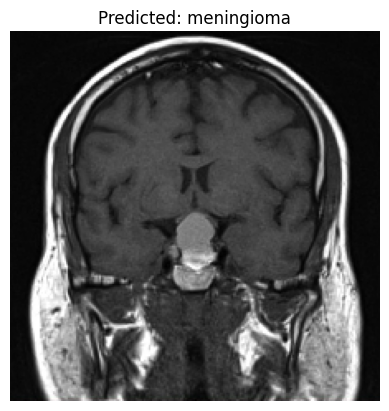

In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = '/content/drive/MyDrive/ext_pit1.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

predicted_class = class_labels[np.argmax(prediction)]
print("Predicted class:", predicted_class)

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


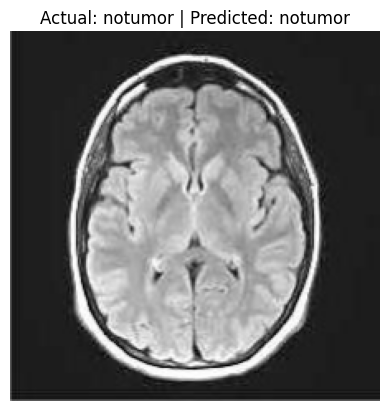

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


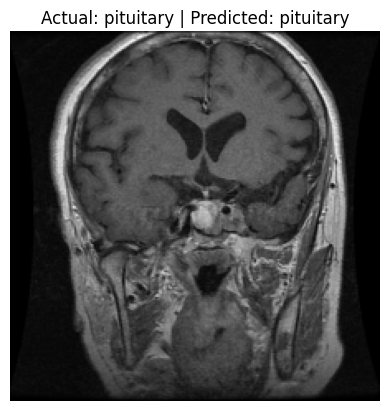

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


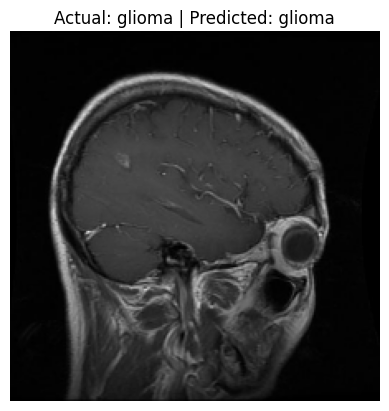

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


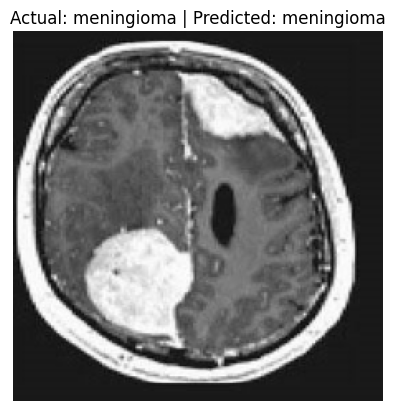

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


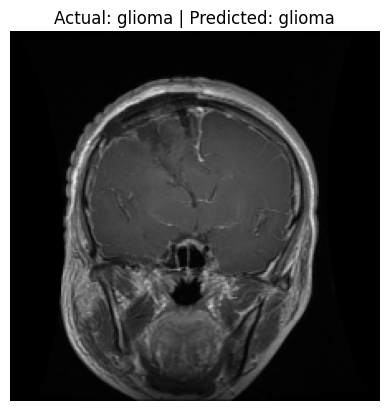

In [15]:
import random
import matplotlib.pyplot as plt

test_dir = "/content/brain_tumor_dataset/Testing"

class_names = sorted(os.listdir(test_dir))

test_images = []
for label in class_names:
    label_path = os.path.join(test_dir, label)
    for img_file in os.listdir(label_path):
        test_images.append((os.path.join(label_path, img_file), label))

sampled_images = random.sample(test_images, 5)

for img_path, true_label in sampled_images:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img_array = img / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_label = class_names[np.argmax(pred)]

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Actual: {true_label} | Predicted: {pred_label}")
    plt.axis('off')
    plt.show()